<a href="https://colab.research.google.com/github/AndreyBertasini/data-engineering/blob/master/ancalitica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
import glob
import missingno as msno

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Наличие корреляции между между странами, полом заёмщика и суммой займа

2. Присутствие аномалий в данных по займам

3. Зависимость уровня бедности от региона проживания пользователей

4. Влияние многомерного индекса бедности в разных странах на суммы займов и сроки погашения



In [ ]:
kiva_loans = pd.read_csv('/content/drive/MyDrive/kiva/kiva_loans.csv').dropna()
kiva_mpi_region_locations = pd.read_csv('/content/drive/MyDrive/kiva/kiva_mpi_region_locations.csv')
loan_theme_id = pd.read_csv('/content/drive/MyDrive/kiva/loan_theme_ids.csv')
loan_themes_by_region = pd.read_csv('/content/drive/MyDrive/kiva/loan_themes_by_region.csv')

1. Наличие корреляции между между странами, полом заёмщика и суммой займа

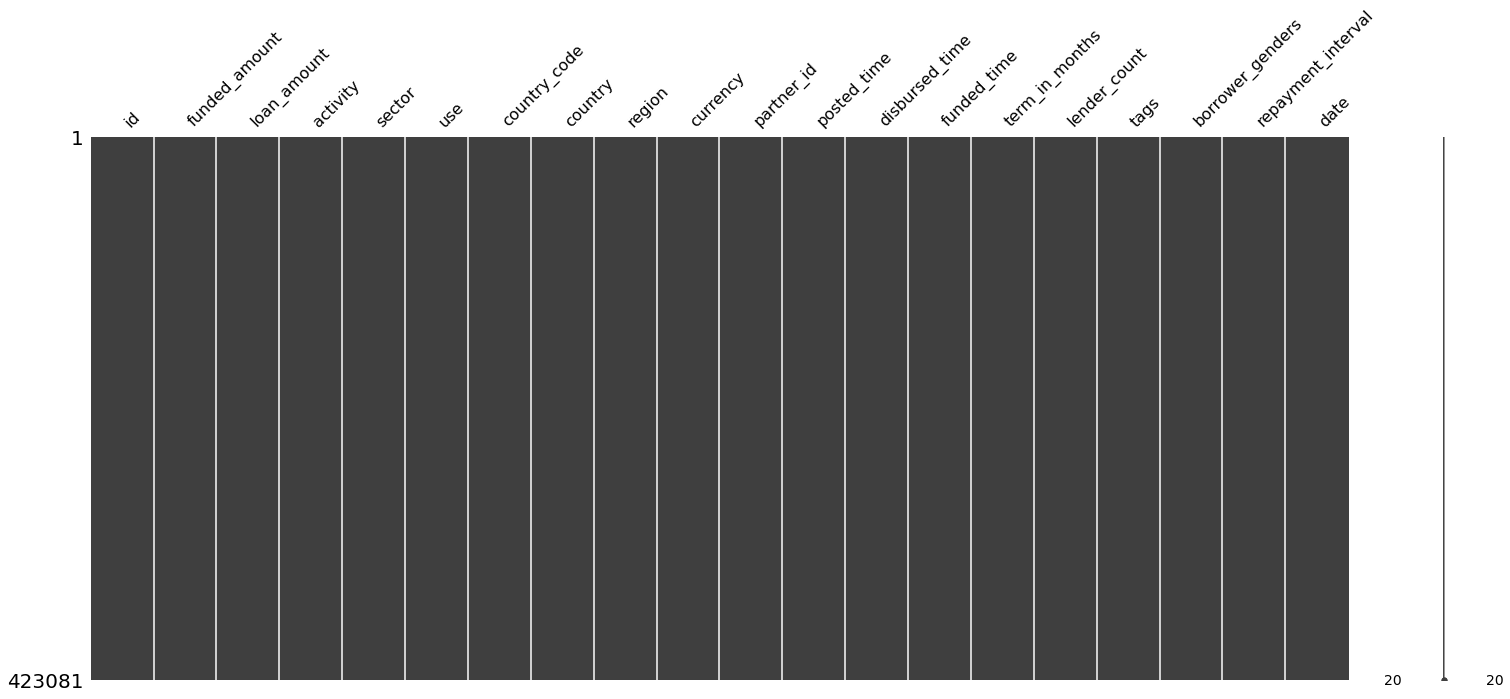

In [ ]:
msno.matrix(kiva_loans)

In [ ]:
kiva_loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
6,653067,200.0,200.0,Dairy,Agriculture,To purchase a dairy cow and start a milk produ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:51:02+00:00,2013-12-16 08:00:00+00:00,2014-01-01 17:18:09+00:00,43.0,8,"user_favorite, user_favorite",female,bullet,2014-01-01
7,653078,400.0,400.0,Beauty Salon,Services,to buy more hair and skin care products.,PK,Pakistan,Ellahabad,PKR,245.0,2014-01-01 11:46:01+00:00,2013-12-20 08:00:00+00:00,2014-01-10 18:18:44+00:00,14.0,8,"#Elderly, #Woman Owned Biz",female,monthly,2014-01-01
8,653082,475.0,475.0,Manufacturing,Manufacturing,"to purchase leather, plastic soles and heels i...",PK,Pakistan,Lahore,PKR,245.0,2014-01-01 11:49:43+00:00,2013-12-20 08:00:00+00:00,2014-01-01 18:47:21+00:00,14.0,19,user_favorite,female,monthly,2014-01-01
12,653089,400.0,400.0,General Store,Retail,"to buy stock of rice, sugar and flour .",PK,Pakistan,Faisalabad,PKR,245.0,2014-01-01 12:04:57+00:00,2013-12-24 08:00:00+00:00,2014-01-08 00:35:14+00:00,14.0,16,"#Repeat Borrower, #Woman Owned Biz",female,monthly,2014-01-01


In [ ]:
kiva_loans['borrower_genders'] = [elem if elem in ['female', 'male'] else 'group' for elem in kiva_loans['borrower_genders'] ]

In [ ]:
kiva_loans['borrower_genders'].isnull().sum()

0

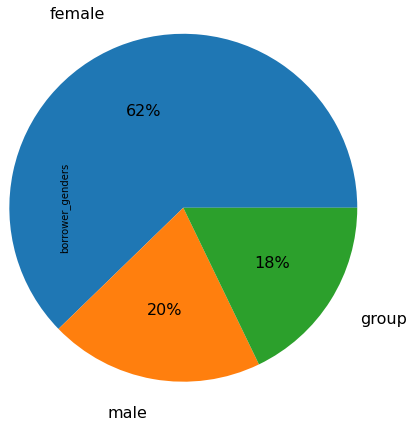

In [ ]:
borrowers = kiva_loans['borrower_genders'].value_counts()

plot = borrowers.plot.pie(fontsize=16, autopct='%1.0f%%', labeldistance=1.2, radius=2)

In [ ]:
kiva = kiva_loans[['country', 'borrower_genders', 'loan_amount']].sort_values('loan_amount',ascending=False).reset_index()

In [ ]:
kiva.head()

,index,country,borrower_genders,loan_amount
0,70499,Haiti,female,100000.0
1,163727,Kenya,female,50000.0
2,548513,Zimbabwe,male,50000.0
3,126839,Mexico,group,50000.0
4,490191,Ghana,male,50000.0


In [ ]:
gender_by_region = kiva_loans.groupby(['country', 'borrower_genders'])['loan_amount'].sum()
gender_by_region.groupby(level=0).apply(lambda x: 100 * x / x.sum())\
.unstack('borrower_genders').fillna(0)

borrower_genders,female,group,male
country,,,
Afghanistan,100.000000,0.000000,0.000000
Albania,50.008471,0.000000,49.991529
Armenia,71.072263,0.000000,28.927737
Azerbaijan,47.921163,2.299409,49.779427
Belize,4.245738,0.000000,95.754262
...,...,...,...
Vanuatu,0.000000,100.000000,0.000000
Vietnam,28.241250,69.110168,2.648583
Yemen,6.361087,42.945730,50.693183


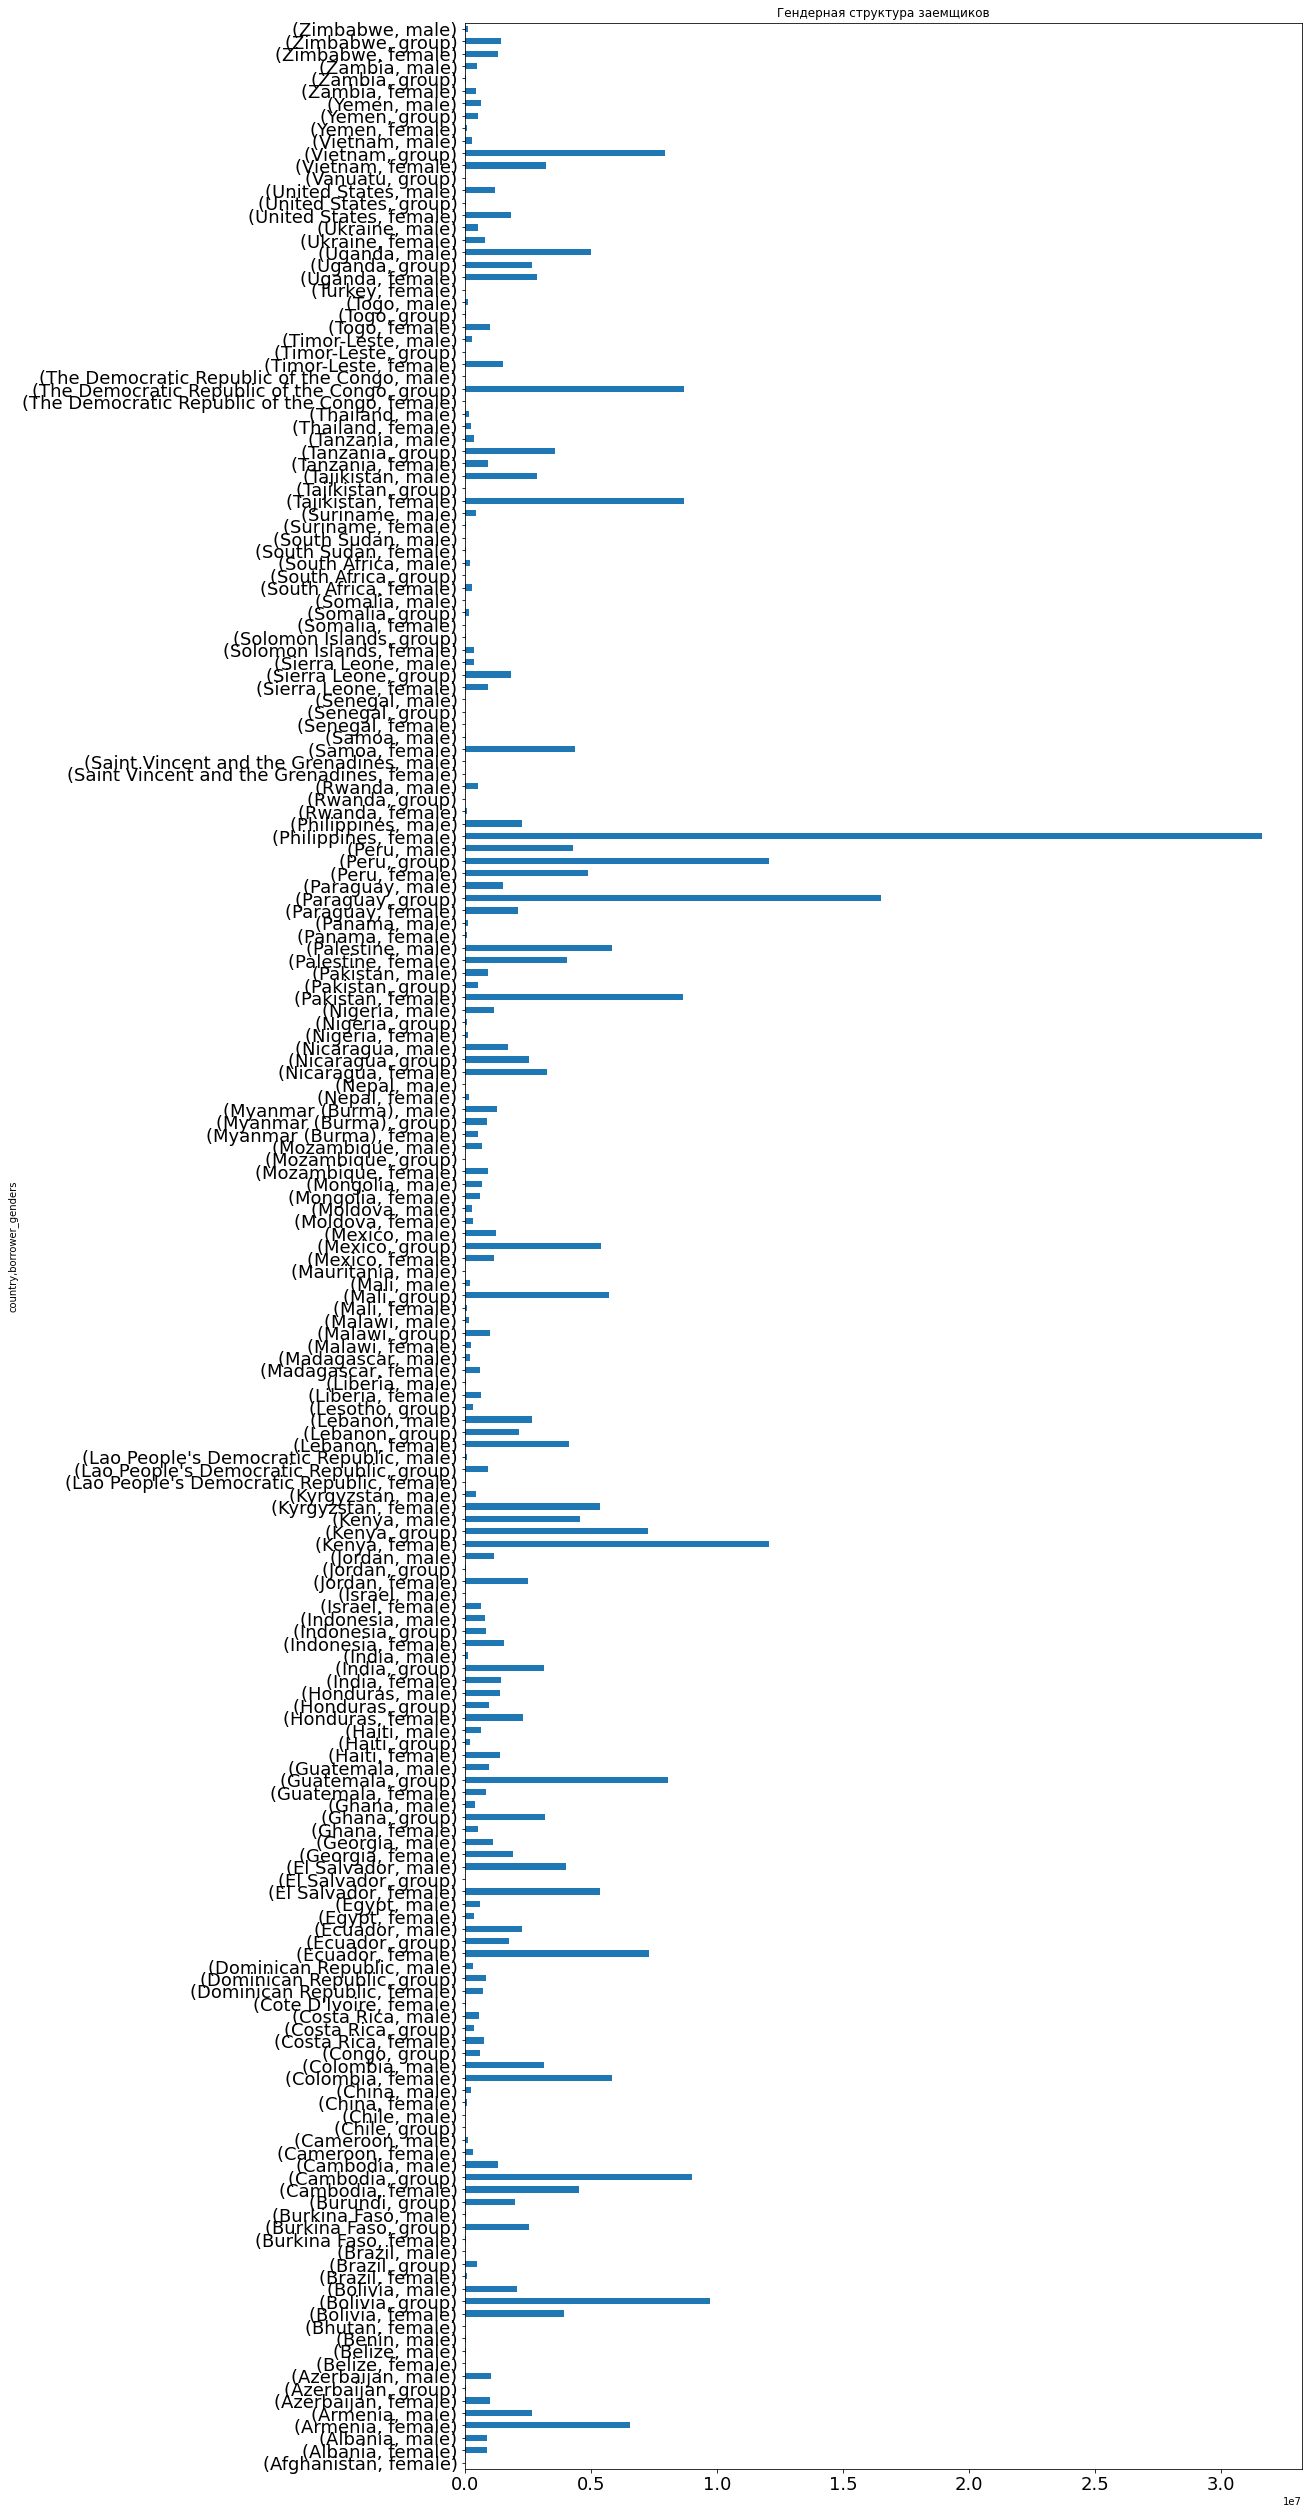

In [ ]:
gender_by_region.plot.barh(
figsize=(15,45),
fontsize=18,
stacked=True,
title='Гендерная структура заемщиков')
plot.title.set_size(25)
plot.legend(loc=1, bbox_to_anchor=(0, 0), fontsize=8)
plot.set(ylabel=None, xlabel=None)
plt.show()

Продолжая изучение регионов, можно заметить, что преобладание женщин в общем объеме кредитования характерно для стран Азии.


2. Присутствие аномалий в данных по займам

Анализ пропущенных значений

In [ ]:
kiva_loans.isna().sum()

id                    0
funded_amount         0
loan_amount           0
activity              0
sector                0
use                   0
country_code          0
country               0
region                0
currency              0
partner_id            0
posted_time           0
disbursed_time        0
funded_time           0
term_in_months        0
lender_count          0
tags                  0
borrower_genders      0
repayment_interval    0
date                  0
dtype: int64

In [ ]:
kiva_loans.dtypes

id                      int64
funded_amount         float64
loan_amount           float64
activity               object
sector                 object
use                    object
country_code           object
country                object
region                 object
currency               object
partner_id            float64
posted_time            object
disbursed_time         object
funded_time            object
term_in_months        float64
lender_count            int64
tags                   object
borrower_genders       object
repayment_interval     object
date                   object
dtype: object

In [ ]:
kiva_loans.describe(include=[np.number])

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count
count,4.230810e+05,423081.000000,423081.000000,423081.000000,423081.000000,423081.000000
mean,1.023395e+06,849.451819,849.451819,183.988165,14.183130,23.465814
std,1.919704e+05,1134.653980,1134.653980,99.563027,8.628768,30.701949
min,6.530470e+05,25.000000,25.000000,9.000000,2.000000,1.000000
25%,8.660230e+05,300.000000,300.000000,126.000000,8.000000,9.000000
50%,1.037726e+06,500.000000,500.000000,154.000000,14.000000,15.000000
75%,1.194290e+06,1000.000000,1000.000000,222.000000,14.000000,29.000000
max,1.339713e+06,100000.000000,100000.000000,535.000000,158.000000,2986.000000


In [ ]:
kiva_loans.describe(include=[np.object])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,activity,sector,use,country_code,country,region,currency,posted_time,disbursed_time,funded_time,tags,borrower_genders,repayment_interval,date
count,423081,423081,423081,423081,423081,423081,423081,423081,423081,423081,423081,423081,423081,423081
unique,163,15,271550,81,81,11258,64,421669,1638,351956,75000,3,3,1291
top,Farming,Agriculture,to buy a water filter to provide safe drinking...,PH,Philippines,Kaduna,PHP,2016-05-17 09:52:10+00:00,2017-02-01 08:00:00+00:00,2016-09-21 13:03:24+00:00,user_favorite,female,monthly,2017-03-20
freq,47363,117496,4592,91317,91317,5825,91316,3,2493,33,24580,263421,230637,1112


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


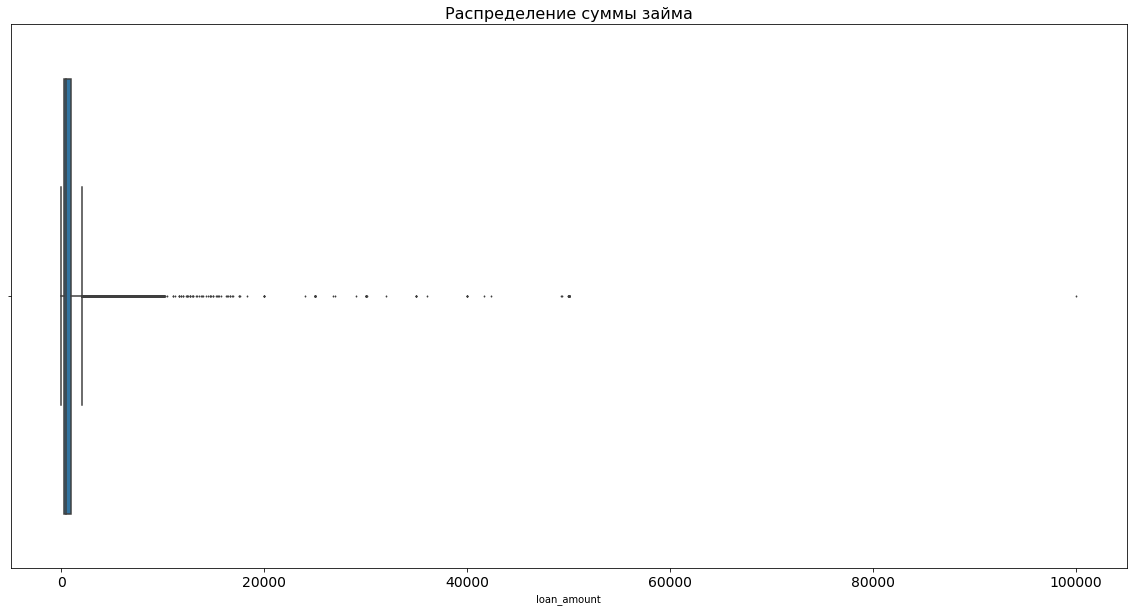

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Распределение суммы займа", fontsize=16)
plt.tick_params(labelsize=14)
sns.boxplot(kiva_loans['loan_amount'], fliersize=True, data = kiva_loans)
plt.show()

все что после максимального значения на графике является выбросом. В данных явные отклонения, Удалим выбросы после 3 сигмы



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


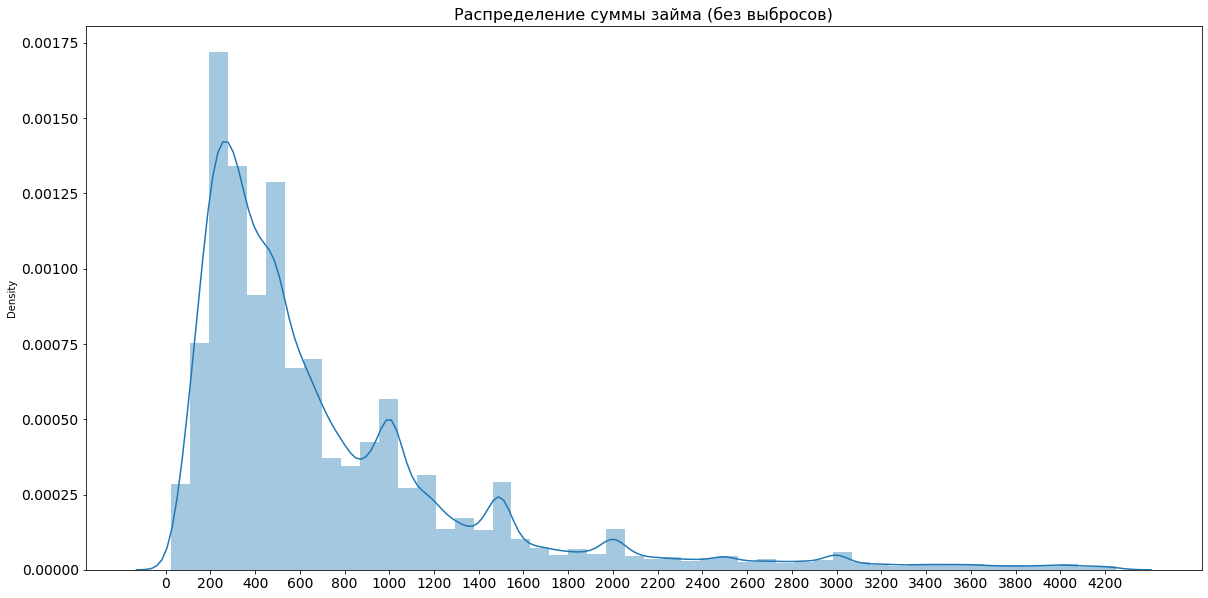

In [ ]:
# Наблюдаемое отклонение от среднего
dev = (kiva_loans['loan_amount']-kiva_loans['loan_amount'].mean()).abs()

# Стандартное отклонение
std = kiva_loans['loan_amount'].std()

# Фильтруем исходный набор данных
kiva_loans_trimmed = kiva_loans[~(dev>3*std)]

plt.figure(figsize=(20,10))
plt.title("Распределение суммы займа (без выбросов)", fontsize=16)
plt.tick_params(labelsize=14)
plt.xticks(np.arange(0, max(kiva_loans_trimmed['loan_amount']+1), 200))

sns.distplot(kiva_loans_trimmed['loan_amount'], axlabel=False)
plt.show()

3. Зависимость уровня бедности от региона проживания пользователей


In [ ]:
kiva_mpi_region_locations.head()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


In [ ]:
mpi_group = kiva_mpi_region_locations.groupby('country')['MPI'].sum().sort_values().reset_index()

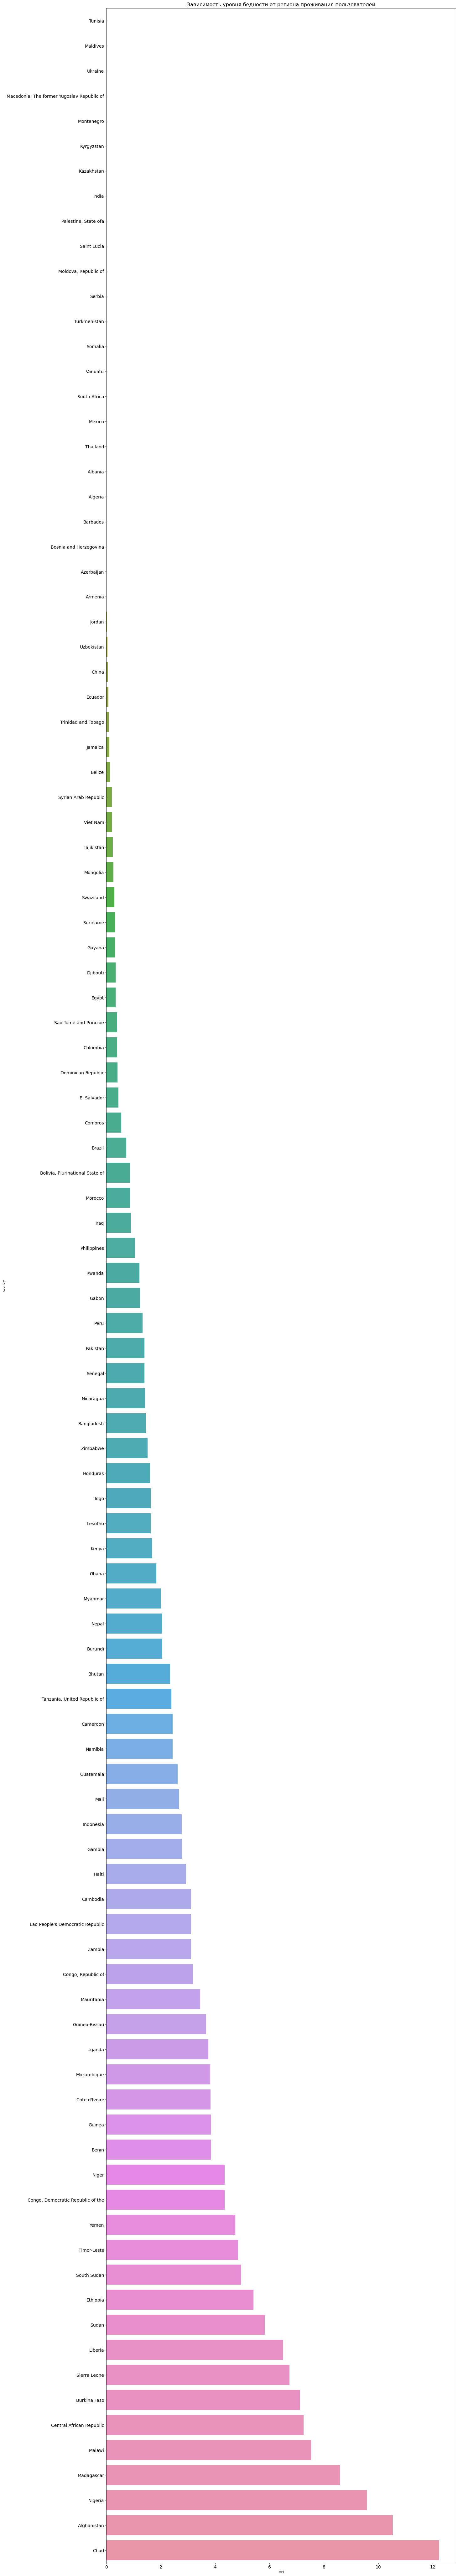

In [ ]:
plt.figure(figsize=(20,150))
plt.title("Зависимость уровня бедности от региона проживания пользователей", fontsize=16)
plt.tick_params(labelsize=14)

sns.barplot(data=mpi_group, x='MPI', y='country')
plt.show()